# Shadowing Envelope

## 0. Initialization

importing all necessary libraries and specifying the inputs

In [1]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np


# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

## 1. Import Meshes

### 1.1 Load Meshes

In [2]:
envelope_path = os.path.relpath('../data/meshes/compulsory_envelope.obj')
context_path = os.path.relpath('../data/meshes/immediate_context.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

True
False


### 1.2 Visualize Meshes 

In [3]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
p.add_mesh(tri_to_pv(envelope_mesh), color='#abd8ff')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x0000028A9B9F4740) at 0x0000028A9C7FF5E0>

## 2. Import Lattice 

### 2.1. Load both the Envelope and Shadow Lattice

In [4]:
# loading the lattice from csv
lattice = os.path.relpath('../data/meshes/voxelized_envelope_highres.csv')
envelope_lattice = tg.lattice_from_csv(lattice)


### 2.2. Visualize the Envelope Lattice

In [5]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x0000028A9B9F2140) at 0x0000028AA47685E0>

### 2.3 Store shadowing information in a Lattice

In [6]:
# Loading the shadow lattice from csv
shadow_lattice = os.path.relpath('../data/fields/shadowing.csv')
shadow_envelope_lattice = tg.lattice_from_csv(shadow_lattice)

### 2.4. Visualize the shadowing

invalid value encountered in true_divide
All-NaN axis encountered


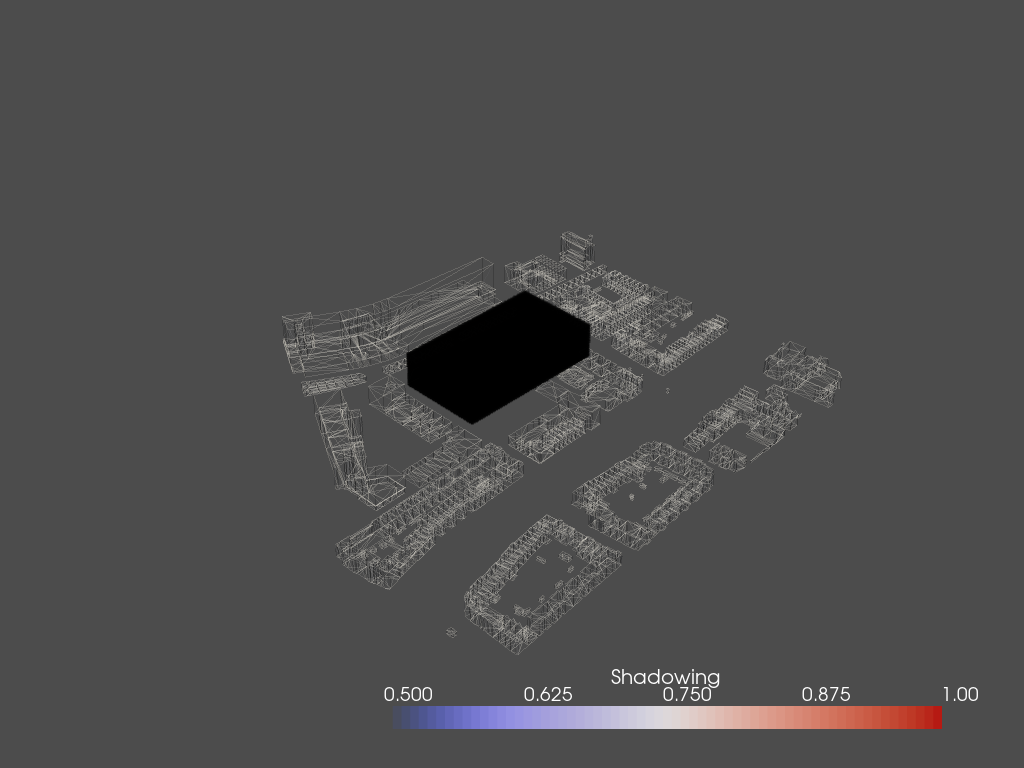

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [7]:
# initiating the plotter
p = pv.Plotter(notebook=True)

l = shadow_envelope_lattice
# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Shadowing"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6])*1.5
p.add_volume(grid, cmap="coolwarm", clim=[0.5, 1.0],opacity=opacity, shade=True)

# plotting
p.show()

## 3. Remove Result in shadow Lattice

### 3.0. Interpolating the shadowing result into higher resolution

### 3.1. Defining maximum shadowing

In [8]:
# defining the shadow envelope lattice with values calcultated in shadowing
shadow_envelope_lattice

# shadowing treshold
shadowing_treshold = 0.3 # number is subject to change

# removing values above set treshold and setting them to zero
new_envelope_lattice = np.where(shadow_envelope_lattice > shadowing_treshold,0,shadow_envelope_lattice)

# set all usable values to 1

usable_lattice = np.where(new_envelope_lattice > 0, 1,new_envelope_lattice)
usable_lattice = usable_lattice.astype(bool)
usable_lattice = tg.to_lattice(usable_lattice, shadow_envelope_lattice)
usable_lattice.shape

(108, 61, 12)

### 3.2. Visualization of leftover voxels

In [9]:
p = pv.Plotter(notebook=True)

base_lattice = usable_lattice

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# # adding the availability lattice
# init_avail_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

def create_mesh(value):

    lattice = (shadow_envelope_lattice < value) * envelope_lattice

    # Add the data values to the cell data
    grid.cell_arrays["Agents"] = lattice.flatten(order="F").astype(int)  # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([0.9, 1.1])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)

    return

p.add_slider_widget(create_mesh, [0, 1.0], title='Time', value=0, event_type="always", style="classic")
p.show(use_ipyvtk=True)

  File "C:\Users\Walter\AppData\Local\Temp/ipykernel_11356/4209675224.py", line 35, in create_mesh
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)
  File "C:\Users\Walter\Anaconda3.2\envs\scds\lib\site-packages\pyvista\plotting\plotting.py", line 1567, in add_mesh
    raise ValueError('Empty meshes cannot be plotted. Input mesh has zero points.')
ValueError: Empty meshes cannot be plotted. Input mesh has zero points.


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.7351488880344, 708.3187438880343, 742.5460610261134),
 (65.08283250000001, -12.333572500000002, 21.89374463807907),
 (0.0, 0.0, 1.0)]

## 4. Finalize Lattice work and save to csv

### 4.1. Save Usable Lattice inta a CSV 

In [10]:
# # save the sun access latice to csv

csv_path = os.path.relpath('../data/meshes/useable_lattice.csv')
usable_lattice.to_csv(csv_path)